In [1]:
import random
from typing import TypedDict, List, Literal
from langgraph.graph import StateGraph, START, END

In [2]:
class AgentState(TypedDict):
    """State for the number guessing game."""
    agent_name: str
    guesses: List[int]
    attempts: int
    lower_bound: int
    upper_bound: int
    target: int
    game_over: bool
    result_message: str


In [5]:
def setup_game(state: AgentState) -> AgentState:
    """Initialize the game state with a random target number."""
    state["agent_name"] = f"Number Guessing Agent '{state['agent_name']}'"
    state['guesses'] = []
    state['attempts'] = 0
    state["game_over"] = False
    state["result_message"] = ""
    state['target'] = random.randint(state['lower_bound'], state['upper_bound'])
    print(f"\n{'='*50}")
    print(f"{state['agent_name']} is ready!")
    print(f"Target range: {state['lower_bound']} - {state['upper_bound']}")
    print(f"Secret number (for debugging): {state['target']}")
    print(f"{'='*50}\n")
    
    return state


def make_guess(state: AgentState) -> AgentState:
    """Make an intelligent guess, avoiding previous guesses."""

    # Build list of numbers we haven't tried yet
    possible_guesses = [
        i for i in range(state["lower_bound"], state["upper_bound"] + 1)
        if i not in state["guesses"]
    ]

    guess = random.choice(possible_guesses)

    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state['attempts']}: Guessed {guess}")
    
    return state

def provide_hint(state: AgentState) -> AgentState:
    """Analyze the guess and update bounds based on feedback."""
    last_guess = state['guesses'][-1]
    target = state["target"]


    if last_guess < target:
        print(f"   Hint: Too low! Try higher.")
        state["lower_bound"] = max(state["lower_bound"], last_guess + 1)
        
    elif last_guess > target:
        print(f"   Hint: Too high! Try lower.")
        state["upper_bound"] = min(state["upper_bound"], last_guess - 1)
        
    else:
        print(f"   CORRECT! You found it!")
        state["game_over"] = True
        state["result_message"] = f"Won in {state['attempts']} attempts!"

    # Show current search range
    if not state["game_over"]:
        print(f"   New range: [{state['lower_bound']}, {state['upper_bound']}]\n")
    
    return state

def should_continue(state: AgentState) -> Literal["continue", "finish"]:
    """Determine if the game should continue or end."""
    if state["game_over"]:
        return "finish"
    return "continue"

def finish_game(state: AgentState) -> AgentState:
    """Display final game results."""
    print(f"\n{'='*50}")
    print(f"GAME OVER!")
    print(f"Result: {state['result_message']}")
    print(f"Target was: {state['target']}")
    print(f"All guesses: {state['guesses']}")
    print(f"{'='*50}\n")
    
    return state


In [6]:
graph = StateGraph(AgentState)


# Add nodes
graph.add_node("setup", setup_game)
graph.add_node("guess", make_guess)
graph.add_node("hint", provide_hint)
graph.add_node("finish", finish_game)
    
# Add edges
graph.add_edge(START, "setup")
graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint")

# Conditional routing: continue guessing or finish
graph.add_conditional_edges(
    "hint",
    should_continue,
    {
        "continue": "guess",
        "finish": "finish"
    }
)
    
graph.add_edge("finish", END)
    
app = graph.compile()

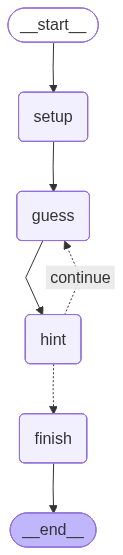

In [7]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
initial_state = {
    "agent_name": "Alex",
    "numbers": [],
    "attempts": 0,
    "lower_bound": 1,
    "upper_bound": 10
}

final_state = app.invoke(initial_state)

print("Final State:", final_state)


Number Guessing Agent 'Alex' is ready!
Target range: 1 - 10
Secret number (for debugging): 9

Attempt 1: Guessed 1
   Hint: Too low! Try higher.
   New range: [2, 10]

Attempt 2: Guessed 3
   Hint: Too low! Try higher.
   New range: [4, 10]

Attempt 3: Guessed 6
   Hint: Too low! Try higher.
   New range: [7, 10]

Attempt 4: Guessed 10
   Hint: Too high! Try lower.
   New range: [7, 9]

Attempt 5: Guessed 8
   Hint: Too low! Try higher.
   New range: [9, 9]

Attempt 6: Guessed 9
   CORRECT! You found it!

GAME OVER!
Result: Won in 6 attempts!
Target was: 9
All guesses: [1, 3, 6, 10, 8, 9]

Final State: {'agent_name': "Number Guessing Agent 'Alex'", 'guesses': [1, 3, 6, 10, 8, 9], 'attempts': 6, 'lower_bound': 9, 'upper_bound': 9, 'target': 9, 'game_over': True, 'result_message': 'Won in 6 attempts!'}
